In [1]:
from logs import logDecorator as lD 
import jsonref, pprint
from lib.databaseIO import pgIO

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
config = jsonref.load(open('../config/config.json'))
logBase = config['logging']['logBase'] + '.modules.module1.module1'
projConfig = jsonref.load(open('../config/modules/module1.json'))

# Querying Data
For the first run, need to download data from the database. <br> 
For subsequent runs, just load from pickle file.

In [4]:
@lD.log(logBase + '.getData')
def getData(logger, query, cols=[], saveData=True, savePath='temp'):

    dbName = projConfig['inputs']['dbName']
    dbVersion = projConfig['inputs']['dbVersion']
    
    data = pgIO.getAllData(query, dbName=dbName)
    df = pd.DataFrame(data)
    if cols != []: df.columns = cols
    if saveData and not os.path.exists(f'../data/{savePath}.pkl'):
        df.to_pickle(f'../data/{savePath}.pkl')
    return df

In [3]:
mdd_filter = pd.read_csv('../data/raw_data/Filters/Mdd_Filter.csv', header=None)
mdd_filter_query = tuple([mdd for mdd in mdd_filter[0]])

In [18]:
mdd_query = f"""select
    distinct pd.patientid
from
    rwe_version1_2.pdiagnose pd
inner join (
    select
        tp.patientid, meds.medication,min(tp.days),
        max(tp.days), count(distinct tp.typepatientid)
    from
        rwe_version1_2.typepatient as tp,
        rwe_version1_2.meds as meds
    where
        tp.typepatientid = meds.typepatientid
    group by
        tp.patientid,
        meds.medication
    having
        max(tp.days) - min(tp.days) >= 120
        and count(distinct tp.typepatientid) >= 3 ) pts on
    pts.patientid = pd.patientid
where
    cast(pd.dsmno as text) in {mdd_filter_query}
    and pd.primary_dx = true ; """
mdd_patients = getData(mdd_query, cols=['PatientID'], savePath='intermediate/mdd_patients')


In [19]:
mdd_patients

,PatientID
0,92
1,2311
2,5890
3,7223
4,7803
5,9209
6,13108
7,20777
8,23025
9,23082


In [21]:
mdd_pts_list = tuple([pt for pt in mdd_patients['PatientID']])
# mdd_pts_list

In [22]:
full_data_query = f"""
select distinct on (tp.typepatientid, pd.diagnosis) tp.patientid, tp.typepatientid, tp.visit_name, tp.visit_type, tp.age, tp.days , bg.sex, bg.race, pd.diagnosis, pd.dsmno, meds.medication, meds.dose, cgi.improvement, cgi.severity
from rwe_version1_2.typepatient tp, rwe_version1_2.background bg, rwe_version1_2.pdiagnose pd, rwe_version1_2.meds meds, rwe_version1_2.cgi cgi
where tp.patientid in {mdd_pts_list}
and tp.patientid = bg.patientid
and tp.typepatientid = pd.typepatientid
and tp.typepatientid = cgi.typepatientid
and tp.typepatientid = meds.typepatientid
"""
cols = ['PatientID', 'VisitID', 'VisitName','VisitType','Age','Days','Sex','Race','Diagnosis','DSMNo','Medication','Dose','CGI-I','CGI-S']
data = getData(full_data_query, cols=cols,savePath='intermediate/full_dataset')

In [23]:
data.head()

,PatientID,VisitID,VisitName,VisitType,Age,Days,Sex,Race,Diagnosis,DSMNo,Medication,Dose,CGI-I,CGI-S
0,92,1667,Progress Note,Outpatient,43,105,F,,Bulimia Nervosa,307.51,fluoxetine,20.0,1.0,2
1,92,1667,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
2,92,1667,Progress Note,Outpatient,43,105,F,,Diagnosis Deferred on Axis II,799.9,fluoxetine,20.0,1.0,2
3,92,1667,Progress Note,Outpatient,43,105,F,,Opioid Dependence,304.00,fluoxetine,20.0,1.0,2
4,92,1668,Progress Note,Outpatient,43,105,F,,Bulimia Nervosa,307.51,fluoxetine,20.0,0.0,1


In [12]:
data.memory_usage(deep=True)

Index               128
PatientID      14205864
VisitID        14205864
VisitName     122600192
VisitType     119080340
Age            14205864
Days           14205864
Sex           117198042
Race          117539145
Diagnosis     160477654
DSMNo         111197921
Medication    119962210
Dose          198882096
CGI-I          14205864
CGI-S          14205864
dtype: int64

## Loading from Pickle

In [4]:
mdd_filter = pd.read_csv('../data/raw_data/Filters/Mdd_Filter.csv', header=None)[0]
#mdd_patients = pickle.load(open('/home/gerpang/VDL/data/intermediate/mdd_patients.pkl','rb'))
data = pickle.load(open('/home/gerpang/VDL/data/intermediate/full_dataset.pkl','rb'))

### Current Patient 

In [7]:
ptX = 458700 # current patient's ID
ptX_data = data.loc[data.PatientID==ptX]

print(f'''---Current Patient---
ID: {ptX}
Age: {ptX_data.Age.max()}
Sex: {ptX_data.Sex.max()}
Race: {ptX_data.Sex.max()}
No. Records: {len(ptX_data)}
''')

---Current Patient---
ID: 458700
Age: 60
Sex: F
Race: F
No. Records: 105



### CGI over Time

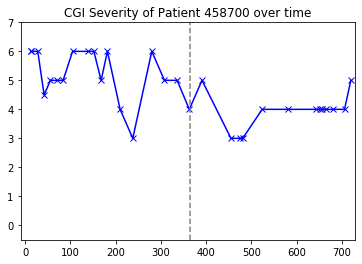

In [69]:
# Patient X's CGI Improvement over time
plt.plot(ptX_data.groupby('Days')['CGI-S'].mean(), label='Severity', marker='x', color='blue')

# Prettifying
ptX_daysmax = ptX_data.Days.max()
for yr in range(ptX_daysmax//365): plt.axvline(x=(yr+1)*365,linestyle='--',c='grey')
plt.axis([-10, ptX_daysmax+10, -0.5,7])
plt.title(f'CGI Severity of Patient {ptX} over time')
plt.savefig('../data/intermediate/cgi_time.png', bbox_inches='tight')
plt.show()

### Comorbidities
1. List the DSM numbers of the patient (and comparative pop) which are not inside the filter list. 
2. Use a separate mapping table to bin the data into the comorbidities list (need to create this)

In [9]:
#Original list of diagnoses for ptX
# pd.DataFrame(ptX_data.Diagnosis.unique(), columns=['Comorbidities'])

## Exclude diagnoses in the mdd_filter
ptX_dsm = pd.DataFrame(ptX_data.DSMNo.unique(), columns=['dsm'])
ptX_dsm[~ptX_dsm.dsm.isin(mdd_filter)]


,dsm
1,V71.09
2,309.81


In [10]:
# Comorbid diseases and number of visits associated with each
ptX_data.groupby('Diagnosis').VisitType.count()

Diagnosis
Major Depressive Disorder, Recurrent, Severe with Psychotic Features    35
No Diagnosis on Axis II                                                 35
Post-Traumatic Stress Disorder                                          35
Name: VisitType, dtype: int64

In [11]:
# Comorbid diseases and days of visits associated with each 
## Tells you when the cormorbidity was diagnosed relative to the disease of interest
ptX_data.groupby('Diagnosis').Days.unique()

Diagnosis
Major Depressive Disorder, Recurrent, Severe with Psychotic Features    [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
No Diagnosis on Axis II                                                 [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
Post-Traumatic Stress Disorder                                          [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
Name: Days, dtype: object

## Comparative Population
Defined as similar primary diagnosis.

In [24]:
pop = data.loc[data.PatientID!=ptX][:1000000] # take a subset for now
pop_mdd = pop.loc[pop.DSMNo.isin(mdd_filter)]

In [28]:
print(f'''
We need to filter for patient records related to MDD-diseases for the medications.
That will narrow the population to {len(pop_mdd)} records.

For comorbidities, we still look at all the records of similar medical profiles,
which means {len(pop)} records.''')


We need to filter for patient records related to MDD-diseases for the medications.
That will narrow the population to 279883 records.

For comorbidities, we still look at all the records of similar medical profiles,
which means 1000000 records.


### CPop % Improved
Using the `pop_mdd` dataset of patients' MDD reocrds:

In [71]:
cpop_meds = pop_mdd.groupby('Medication').agg({'PatientID':'nunique', 'CGI-S':'mean'})

cpop_improved = pop_mdd.loc[pop['CGI-S']<=2].groupby('Medication').agg({'PatientID':'nunique', 'CGI-S':['mean','median','var']})

cpop_all = cpop_meds.merge(cpop_improved, how='left', on='Medication')
cpop_all.columns = ['Count_All','CGI-S_All','Count_Improved','CGI-S_Mean','CGI-S_Median','CGI-S_Var']
cpop_all['Pct_Improved'] = cpop_all.Count_Improved / cpop_all.Count_All * 100 
cpop_all.sort_values(['Count_All'], ascending=False)

/home/gerpang/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Count_All,CGI-S_All,Count_Improved,CGI-S_Mean,CGI-S_Median,CGI-S_Var,Pct_Improved
Medication,,,,,,,
sertraline,1395,3.773161,373.0,1.510542,2.0,0.249992,26.738351
citalopram,1276,3.876042,363.0,1.452113,1.0,0.247839,28.448276
trazodone,1223,4.044069,298.0,1.322423,1.0,0.221406,24.366312
clonazepam,1183,3.938019,294.0,1.518130,2.0,0.249910,24.852071
bupropion,1109,3.873280,320.0,1.551700,2.0,0.251666,28.854824
escitalopram,1093,4.059333,257.0,1.406077,1.0,0.242727,23.513266
zolpidem,1020,3.751776,289.0,1.509697,2.0,0.250100,28.333333
quetiapine,990,4.083084,197.0,1.280397,1.0,0.202025,19.898990
fluoxetine,977,4.014491,246.0,1.528511,2.0,0.249399,25.179120


[Plotting the Confidence Intervals of Improved Population](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py)

Using Top 10 Medications (by patient count) first: 
- Remove NA
- For each Medication
- plot a boxplot

In [103]:
top10meds = cpop_all.sort_values(['Count_All'], ascending=False).index[:10]
top10meds_cgi = pop_mdd.loc[pop_mdd['Medication'].isin(top10meds)].groupby(['Medication'])['CGI-I'].apply(list)

for i, med in enumerate(top10meds_cgi): 
    top10meds_cgi[i] = [m for m in top10meds_cgi[i] if ~np.isnan(m)] #list(filter(None,top10meds_cgi[i]))
top10meds_cgi

Medication
aripiprazole    [2.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...
bupropion       [0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 4.0, 3.0, ...
citalopram      [4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, ...
clonazepam      [1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 0.0, 4.0, ...
escitalopram    [2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...
fluoxetine      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
quetiapine      [3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 3.0, 2.0, ...
sertraline      [3.0, 3.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...
trazodone       [0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, ...
zolpidem        [0.0, 4.0, 5.0, 0.0, 2.0, 4.0, 5.0, 3.0, 3.0, ...
Name: CGI-I, dtype: object

In [86]:
# Extract percentage improved from the cpop_all dataframe
pct_imp = cpop_all[cpop_all.index.isin(top10meds_cgi.index)]['Pct_Improved']

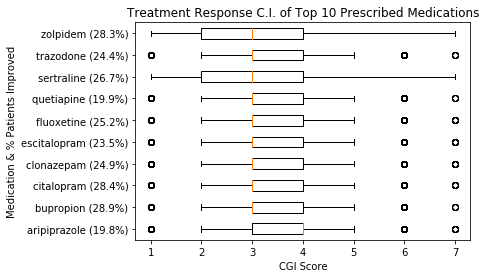

In [102]:
fig, ax = plt.subplots()
bp_data = top10meds_cgi
plt.boxplot(bp_data, vert=False)

ax.set_yticklabels([f'{med_name} ({round(pct,1)}%)' for med_name, pct in zip(top10meds_cgi.index, pct_imp)])
ax.set_title('Treatment Response C.I. of Top 10 Prescribed Medications')
ax.set_ylabel('Medication & % Patients Improved')
ax.set_xlabel('CGI Score')
plt.savefig('../data/intermediate/cgi_improvement.png', bbox_inches='tight')
plt.show()

### CPop Comorbidities

In [104]:
pop_comorbid = pop[~pop.DSMNo.isin(mdd_filter)].groupby(['DSMNo','Diagnosis']).PatientID.nunique()
pd.DataFrame(pop_comorbid).sort_values('PatientID',ascending=False)[:10]

,,PatientID
DSMNo,Diagnosis,
799.9,Diagnosis Deferred on Axis II,4034
V71.09,No Diagnosis on Axis II,1220
309.81,Post-Traumatic Stress Disorder,1151
300.00,Anxiety Disorder NOS,1143
300.02,Generalized Anxiety Disorder,1103
301.83,Borderline Personality Disorder,604
296.90,Mood Disorder NOS,576
303.90,Alcohol Dependence,536
301.9,Personality Disorder NOS,446


### CPop CGI Against Time
- From Comparative Population (excl PtX) 
- MDD-related records
- For each medication prescribed
- Median +CI CGI scores of patient group over time 

In [107]:
pop_mdd

,PatientID,VisitID,VisitName,VisitType,Age,Days,Sex,Race,Diagnosis,DSMNo,Medication,Dose,CGI-I,CGI-S
1,92,1667,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
5,92,1668,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
9,92,1669,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
13,92,1673,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
17,92,1674,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
21,92,1675,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
25,92,1677,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
29,92,1679,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
33,92,1681,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
37,92,1691,Progress Note,Outpatient,43,99,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1


### For a particular medication
e.g. buproprion

In [136]:
bupropion_cgi = pop_mdd[pop_mdd.Medication =='bupropion'].groupby('Days').agg({'CGI-S':'median'}) #['CGI-S'].apply(list)
bupropion_cgi

,CGI-S
Days,
0,4.0
1,6.0
2,5.0
3,5.0
4,5.0
5,5.0
6,4.0
7,4.0
8,4.5


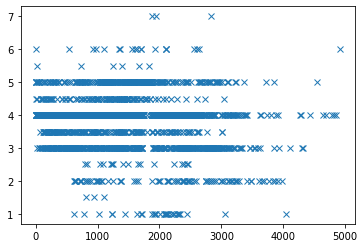

In [140]:
plt.plot(bupropion_cgi,marker='x',linestyle='')

Time period looks way too long here. Supposed to reduce to within the patient's time of visit? need to define these terms better.